## Подготовка

In [ ]:
# pip install PyPortfolioOpt
# pip install pandas_datareader

### Импорты

In [94]:
import numpy as np
import pandas as pd
from pandas_datareader import data

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

import yfinance as yf
import pandas_datareader as pdr

### Сбор данных

[Источник данных по голубым фишкам на МосБирже](https://investfunds.ru/stocks/?auto=1&limit=50)

In [3]:
blue_chips_names = np.array(
    [
        'POLY', 'FIVE', 'GAZP', 'GMKN', 'LKOH', 'MGNT',	'MTSS', 'NLMK', 'NVTK', 'PLZL', 'ROSN', 'SBER', 'SNGS', 'TATN', 'YNDX'
    ]
)
blue_chips_names.astype(str)

blue_chips_mcap = np.array(
    [
        2_795.81, 6_587.80, 43_593.26, 29_192.51, 56_314.28, 7_334.82, 5_784.72, 11_889.03, 51_179.51, 17_013.63, 70_979.28, 67_433.18, 12_825.20, 15_703.95, 10_500.55
    ]
)

df_blue_chips = pd.DataFrame(
    {
        'names': blue_chips_names,
        'MCap': blue_chips_mcap
    }
)
df_blue_chips.sort_values(by='MCap', ascending=False, inplace=True)
df_blue_chips.reset_index(inplace=True, drop=True)
df_blue_chips

,names,MCap
0,ROSN,70979.28
1,SBER,67433.18
2,LKOH,56314.28
3,NVTK,51179.51
4,GAZP,43593.26
5,GMKN,29192.51
6,PLZL,17013.63
7,TATN,15703.95
8,SNGS,12825.20
9,NLMK,11889.03


In [ ]:
# initial_date = "2020-04-20"
# today = datetime.today().strftime('%Y-%m-%d')

# # download dataframe
# data = pdr.get_data_moex(['FIVE'], start=initial_date, end=today)['CLOSE']
# data

# type(data)

In [ ]:
# data1 = pdr.get_data_moex(['GMKN'], start=initial_date, end=today)['CLOSE']
# data1

In [ ]:
# data2 = pdr.get_data_moex(['FIVE', 'GMKN'], start=initial_date, end=today)['CLOSE']
# data2

In [4]:
def make_stock_table(start_date, end_date, stocks=blue_chips_names, market_proxy='IMOEX'):
    df = pd.DataFrame()
    for stock in stocks:
        cur_series = pdr.get_data_moex(stock, start=start_date, end=end_date)['CLOSE']
        df[stock] = cur_series
    cur_series = pdr.get_data_moex(market_proxy, start=start_date, end=end_date)['CLOSE']
    df_market_proxy = cur_series.to_frame()
    del cur_series

    return df, df_market_proxy

In [5]:
import warnings
warnings.filterwarnings('ignore')

# берем данные за 5 лет
df_assets, df_benchmark = make_stock_table('31-10-2018', '31-10-2023')

In [6]:
df_assets

,POLY,FIVE,GAZP,GMKN,LKOH,MGNT,MTSS,NLMK,NVTK,PLZL,ROSN,SBER,SNGS,TATN,YNDX
TRADEDATE,,,,,,,,,,,,,,,
2018-10-31,608.0,1539.0,155.47,11000.0,4945.0,3590.0,257.60,160.42,1049.8,4152.0,460.45,189.80,26.570,784.4,1916.5
2018-11-01,624.0,1598.5,153.50,11250.0,4937.0,3640.0,258.25,159.06,1082.1,4148.5,460.00,188.67,26.500,779.0,1999.0
2018-11-02,619.4,1614.5,153.71,11470.0,4980.0,3660.0,262.20,157.94,1080.4,4185.0,459.60,192.60,26.685,792.7,1995.0
2018-11-06,615.0,1629.5,156.00,11565.0,5055.0,3695.0,264.00,157.92,1081.6,4214.0,482.45,197.80,27.030,802.2,2002.0
2018-11-07,625.0,1640.0,157.85,11695.0,5174.5,3720.0,270.95,157.60,1103.8,4247.0,484.10,201.90,27.305,814.1,1995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,549.5,2414.5,169.62,17460.0,7437.5,6046.5,283.85,191.68,1695.0,11756.0,590.50,273.73,33.240,622.3,2737.0
2023-10-26,543.0,2372.0,168.45,17250.0,7228.5,5913.0,279.55,192.10,1682.0,11577.0,583.00,269.90,32.575,613.6,2682.4
2023-10-27,547.3,2366.0,167.26,17506.0,7318.0,6015.0,282.15,191.50,1678.4,11726.0,594.60,269.70,32.785,622.4,2666.6


In [10]:
df_benchmark.rename(columns={'CLOSE': "IMOEX"}, inplace=True)
df_benchmark

,IMOEX
TRADEDATE,
2018-10-31,2352.71
2018-11-01,2359.33
2018-11-02,2377.95
2018-11-06,2412.31
2018-11-07,2445.34
...,...
2023-10-25,3265.28
2023-10-26,3223.89
2023-10-27,3224.18


In [11]:
def plot_stock_performance(df1, df2=None, df2_col='IMOEX'):
    plt.figure(figsize=(12, 5))
    for col in df1.columns.values:
        sns.lineplot(data=df1[col], label=col)
    sns.lineplot(data=df2[df2_col], label=df2_col, linestyle='--')
    plt.title('Price of the Stocks')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Price in RUR', fontsize=18)
    plt.legend(
        np.append(df1.columns.values, df2_col), loc='upper left'
    )
    plt.show();

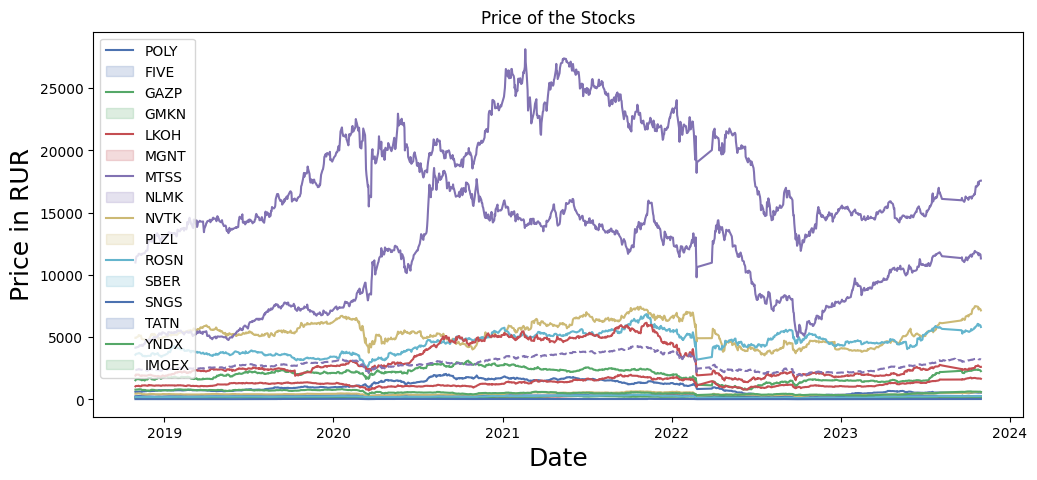

In [12]:
plot_stock_performance(df1=df_assets, df2=df_benchmark)

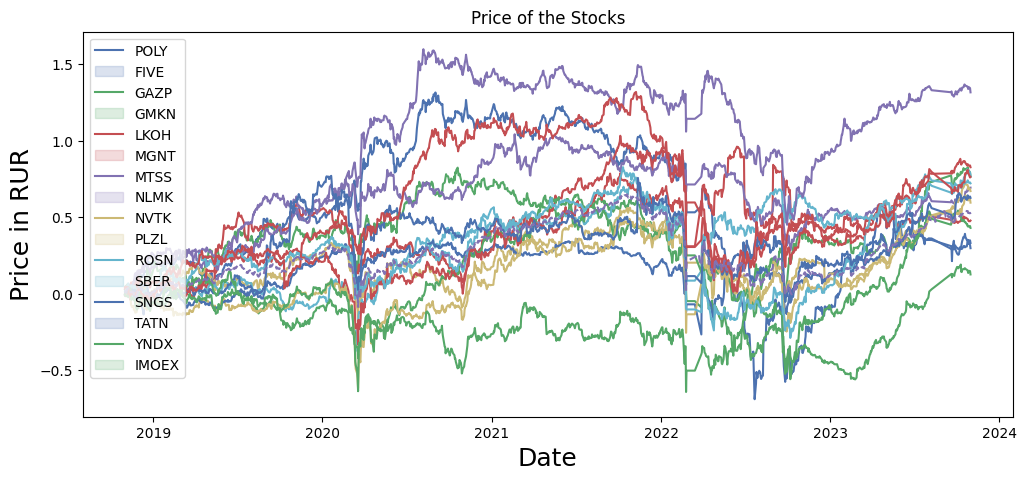

In [15]:
plot_stock_performance(
    df1=df_assets.pct_change()[1:].cumsum(), 
    df2=df_benchmark.pct_change()[1:].cumsum()
)

In [ ]:
# df = np.log(df).diff()
# df = df.dropna()
# df

In [ ]:
# Are in fact the returns normally distributed?

# plt.figure(figsize=(12.2,4.5)) 
# for i in df.columns.values:
#     plt.hist( df[i],  label=i, bins = 200)
# plt.title('Returns Histogram')
# plt.xlabel('Fecha',fontsize=18)
# plt.ylabel('Precio en USD',fontsize=18)
# plt.legend(df.columns.values)
# plt.show();

## Построение портфеля

### Предпосылки

1. Не имеем доступа к зарубежным рынкам (по крайней мере в краткосрочной перспективе)
   
   - минимизируем политические риски заморозки активов
   - семья не имеет финансового образования и опыта в торговле на финансовых рынках, поэтому торговля на зарубежных рынках сопряжена и с бОльшими финансовыми рисками

<br>

2. Инвестируем в следующие классы активов: акции, облигации, депозиты, commodities?
   
   - деривативы являются более рисковым финансовым инструментом по сравнению с "более классическими" активами и в основном используются при построении стратегий ??
   - в семье нет квалифицированных инвесторов (если мы только рекомендуем активы, то ок; если же мы занимаемся доверительным управлением, то лажа)
   - насколько я понимаю, торговля commodities доступна только через фьючерсы, а этот фин. инструмент не доступен не квалифицированным инвесторам (или людям, прошедшим тест на знание соответствующих фин. инструментов)

<br>

3. Соотношение активов в портфеле: ? / ? / ? (...)
   
   - ...
   - ...

<br>

4. ERP = ...
5. Какой берем RFR?

### Подбор оптимальных весов

In [16]:
df_assets_performance = df_assets.pct_change()[1:]
df_benchmark_performance = df_benchmark.pct_change()[1:]

In [17]:
df_assets_performance

,POLY,FIVE,GAZP,GMKN,LKOH,MGNT,MTSS,NLMK,NVTK,PLZL,ROSN,SBER,SNGS,TATN,YNDX
TRADEDATE,,,,,,,,,,,,,,,
2018-11-01,0.026316,0.038661,-0.012671,0.022727,-0.001618,0.013928,0.002523,-0.008478,0.030768,-0.000843,-0.000977,-0.005954,-0.002635,-0.006884,0.043047
2018-11-02,-0.007372,0.010009,0.001368,0.019556,0.008710,0.005495,0.015295,-0.007041,-0.001571,0.008798,-0.000870,0.020830,0.006981,0.017587,-0.002001
2018-11-06,-0.007104,0.009291,0.014898,0.008282,0.015060,0.009563,0.006865,-0.000127,0.001111,0.006930,0.049717,0.026999,0.012929,0.011984,0.003509
2018-11-07,0.016260,0.006444,0.011859,0.011241,0.023640,0.006766,0.026326,-0.002026,0.020525,0.007831,0.003420,0.020728,0.010174,0.014834,-0.003497
2018-11-08,0.008800,-0.018293,-0.002154,0.000257,-0.002802,0.004032,0.009780,-0.005076,-0.015039,0.003061,-0.018798,0.004903,-0.002930,0.006265,-0.006516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,0.006964,0.005623,-0.003349,0.015352,-0.000873,-0.004364,0.013388,-0.014296,0.009289,-0.000255,0.007335,0.009068,0.012797,-0.005116,0.004330
2023-10-26,-0.011829,-0.017602,-0.006898,-0.012027,-0.028101,-0.022079,-0.015149,0.002191,-0.007670,-0.015226,-0.012701,-0.013992,-0.020006,-0.013980,-0.019949
2023-10-27,0.007919,-0.002530,-0.007064,0.014841,0.012382,0.017250,0.009301,-0.003123,-0.002140,0.012870,0.019897,-0.000741,0.006447,0.014342,-0.005890


In [18]:
df_benchmark_performance

,IMOEX
TRADEDATE,
2018-11-01,0.002814
2018-11-02,0.007892
2018-11-06,0.014449
2018-11-07,0.013692
2018-11-08,-0.002748
...,...
2023-10-25,0.000083
2023-10-26,-0.012676
2023-10-27,0.000090


In [47]:
# считаем cov(r_i, r_m) -- ковариацию доходности каждой акции и индекса
# считаем sigma^2_m -- дисперсию рыночной доходности
# считаем beta для каждой акции

def calc_betas(df1, df2=None, df2_col='IMOEX'):
    dict_assets_covariance_imoex = {}
    for col in df1.columns.values:
        dict_assets_covariance_imoex[col] = df1[col].cov(df2[df2_col])
    
    mkt_disp = df2[df2_col].std(ddof=0) ** 2
    dict_asset_betas = {
        ticker: cov / mkt_disp for ticker, cov in dict_assets_covariance_imoex.items()
    }
    return dict_asset_betas


In [48]:
asset_daily_betas = calc_betas(
    df1=df_assets_performance, df2=df_benchmark_performance
)
asset_daily_betas

{'POLY': 0.5821042116348978,
 'FIVE': 0.7228534397119908,
 'GAZP': 1.009898073943667,
 'GMKN': 0.6536167144017081,
 'LKOH': 0.91088128766574,
 'MGNT': 0.7213700565372332,
 'MTSS': 0.6300499319540417,
 'NLMK': 0.6459778310623812,
 'NVTK': 0.8905581174370623,
 'PLZL': 0.56005912380799,
 'ROSN': 1.0559939249185426,
 'SBER': 1.0603878346201083,
 'SNGS': 0.9269266568571578,
 'TATN': 1.028916515338117,
 'YNDX': 0.9000112120504832}

In [ ]:
# (
#     students[
#         students['Family Name'] == 'Smith'
#     ]
#     .groupby('Gender')
#     .Grade
#     .mean()
# )

# df.groupby(['Name', 'Gender']).mean()

In [ ]:
###
df_benchmark_performance.head(21)

In [67]:
###
df_benchmark_performance['IMOEX'].std(ddof=0)

0.01779253874277225

In [69]:
###
df_benchmark_performance.resample('M').mean().std(ddof=0)

IMOEX    0.003788
dtype: float64

In [68]:
###
monthly_average_returns.std(ddof=0)

IMOEX    0.008361
dtype: float64

In [85]:
def check_beta_sustainability(df1, df2):
    df_11 = df1.copy(); df_21 = df2.copy()
    daily_betas = calc_betas(df_11, df_21)

    df_sust = pd.DataFrame.from_dict(
        daily_betas, orient='index', columns=['daily_beta']
    )

    monthly_1_betas = calc_betas(
        df_11.loc[df_11.index.is_month_start], df_21.loc[df_21.index.is_month_start]
    )
    series_tmp = pd.Series(monthly_1_betas)
    df_sust['monthly_1_beta'] = series_tmp
    del series_tmp

    monthly_last_betas = calc_betas(
        df_11.loc[df_11.index.is_month_end], df_21.loc[df_21.index.is_month_end]
    )
    series_tmp = pd.Series(monthly_last_betas)
    df_sust['monthly_last_beta'] = series_tmp
    del series_tmp

    monthly_avg_betas = calc_betas(
        df_11.resample('M').mean(), df_21.resample('M').mean()
    )
    series_tmp = pd.Series(monthly_avg_betas)
    df_sust['monthly_avg_beta'] = series_tmp
    del series_tmp

    monthly_cumulative_betas = calc_betas(
        df_11.resample('M').sum(), df_21.resample('M').sum()
    )
    series_tmp = pd.Series(monthly_cumulative_betas)
    df_sust['monthly_cumulative_beta'] = series_tmp
    del series_tmp

    return df_sust

In [86]:
all_betas = check_beta_sustainability(
    df_assets_performance, df_benchmark_performance
).round(decimals=4)

all_betas

,daily_beta,monthly_1_beta,monthly_last_beta,monthly_avg_beta,monthly_cumulative_beta
POLY,0.5821,0.4380,0.7695,1.2014,1.1952
FIVE,0.7229,0.1455,1.0088,1.2994,1.0545
GAZP,1.0099,1.5303,3.0454,0.8773,0.9809
GMKN,0.6536,1.4119,0.3420,0.6603,0.6172
LKOH,0.9109,0.7970,1.0065,1.1537,1.0880
MGNT,0.7214,0.5449,0.6032,1.4157,1.0513
MTSS,0.6300,0.2705,0.2045,0.9187,0.7417
NLMK,0.6460,0.2635,0.5969,0.3938,0.6341
NVTK,0.8906,0.7120,0.3511,1.5848,1.2429
PLZL,0.5601,0.7015,0.5815,0.9433,0.7722


Из таблицы выше мы видим, что наиболее стабильными (в смысле близости значений) коэффициентами `beta` являются beta, посчитанные по месячным данным (средняя за месяц дневная доходность и накопленная за месяц доходность), поэтому далее будем работать с ними  

<sub>(а точнее, с beta, посчитанной по средним за месяц доходностям, т.к. такой метод потенциально более точный из-за возможного смещения в beta из последнего столбца по причине разного количества торговых дней в месяцах). </sub>

Безрисковая ставка (`rfr`) является годовой спот-ставкой [кривой бескупонной доходности государственных облигаций](https://www.cbr.ru/hd_base/zcyc_params/zcyc/) со сроком погашения 20 лет. 

Премия за риск (`erp`) является также годовой ожидаемой риск-премией российского рынка акций над безрисковой ставкой (совпадение сроков инвестирования??) взята нами из [статьи БКС](https://bcs-express.ru/novosti-i-analitika/rezul-taty-oprosa-premiia-za-risk-kakoi-ona-dolzhna-byt). 

In [92]:
rfr = 11.92 / 100
erp = 0.10
exp_returns = rfr + all_betas.monthly_avg_beta * erp
exp_returns * 100

POLY    23.934
FIVE    24.914
GAZP    20.693
GMKN    18.523
LKOH    23.457
MGNT    26.077
MTSS    21.107
NLMK    15.858
NVTK    27.768
PLZL    21.353
ROSN    32.341
SBER    25.619
SNGS    22.764
TATN    23.087
YNDX    25.897
Name: monthly_avg_beta, dtype: float64

In [103]:
def make_corr_mat(df):
    corr_mat = df.corr()
    plt.figure(figsize=(12, 5))
    sns.heatmap(corr_mat, annot = True)
    plt.title('Correlation Matrix')
    plt.xlabel('Assets', fontsize=18)
    plt.ylabel('Assets', fontsize=18)
    plt.show();

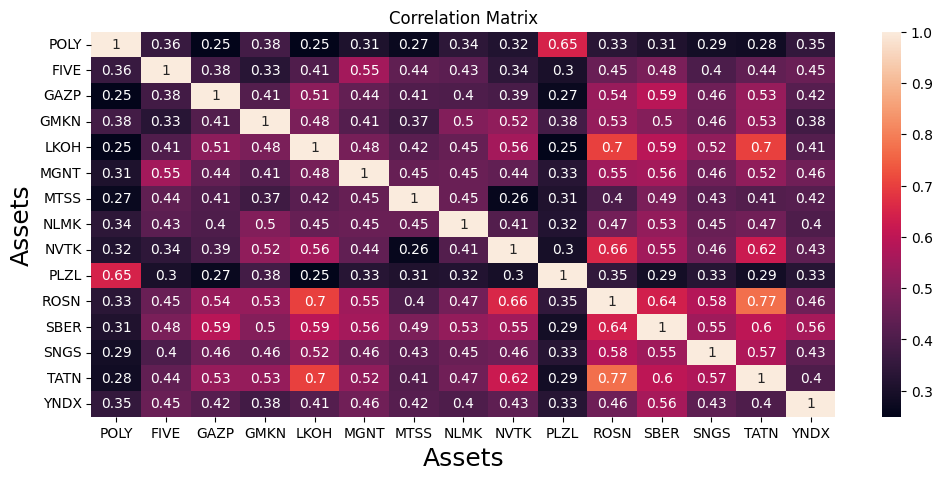

In [104]:
make_corr_mat(df_assets_performance)

In [102]:
assets_cov = df_assets_performance.cov() * 252
assets_cov

,POLY,FIVE,GAZP,GMKN,LKOH,MGNT,MTSS,NLMK,NVTK,PLZL,ROSN,SBER,SNGS,TATN,YNDX
POLY,0.186993,0.061373,0.043589,0.050364,0.037770,0.045443,0.037079,0.047861,0.053396,0.099813,0.054793,0.051297,0.051717,0.047781,0.063753
FIVE,0.061373,0.153366,0.059489,0.039610,0.055694,0.073624,0.054453,0.054800,0.052265,0.042299,0.067789,0.071854,0.064839,0.067256,0.074463
GAZP,0.043589,0.059489,0.159926,0.050144,0.072006,0.059774,0.051948,0.052930,0.061293,0.038543,0.081758,0.090161,0.076655,0.083577,0.070201
GMKN,0.050364,0.039610,0.050144,0.093088,0.051643,0.042952,0.036423,0.049762,0.061954,0.041740,0.061757,0.058262,0.057820,0.063181,0.048730
LKOH,0.037770,0.055694,0.072006,0.051643,0.122621,0.056563,0.047438,0.051223,0.076074,0.031549,0.093825,0.078793,0.075602,0.096523,0.061047
MGNT,0.045443,0.073624,0.059774,0.042952,0.056563,0.115243,0.048422,0.050371,0.058251,0.039881,0.070939,0.071977,0.065135,0.069370,0.066282
MTSS,0.037079,0.054453,0.051948,0.036423,0.047438,0.048422,0.102038,0.047437,0.032856,0.035753,0.048382,0.059204,0.056304,0.051538,0.056130
NLMK,0.047861,0.054800,0.052930,0.049762,0.051223,0.050371,0.047437,0.107038,0.052830,0.037296,0.058936,0.065669,0.061184,0.059606,0.055370
NVTK,0.053396,0.052265,0.061293,0.061954,0.076074,0.058251,0.032856,0.052830,0.152919,0.041357,0.097917,0.081936,0.074952,0.095527,0.071307
PLZL,0.099813,0.042299,0.038543,0.041740,0.031549,0.039881,0.035753,0.037296,0.041357,0.127871,0.047375,0.039351,0.048451,0.039962,0.049406


In [ ]:
ef = EfficientFrontier(exp_returns, assets_cov, weight_bounds=(0,1))
opt_weights = ef.max_sharpe()
opt_weights

In [109]:
cleaned_opt_weights = ef.clean_weights() 
cleaned_opt_weights

OrderedDict([('POLY', 0.05382),
             ('FIVE', 0.04614),
             ('GAZP', 0.0),
             ('GMKN', 0.0),
             ('LKOH', 0.0),
             ('MGNT', 0.18885),
             ('MTSS', 0.17956),
             ('NLMK', 0.0),
             ('NVTK', 0.12028),
             ('PLZL', 0.11743),
             ('ROSN', 0.26897),
             ('SBER', 0.0),
             ('SNGS', 0.0),
             ('TATN', 0.0),
             ('YNDX', 0.02495)])

In [127]:
def make_pie_graph_weights(dict_weights):
    dict_weights_non_zero = {
        key: dict_weights[key] for key in dict_weights if dict_weights[key] != 0
    }

    colors = sns.color_palette('pastel')
    plt.pie(
        dict_weights_non_zero.values(), labels=dict_weights_non_zero.keys(), colors=colors, autopct='%.1f%%'
    )
    plt.show();

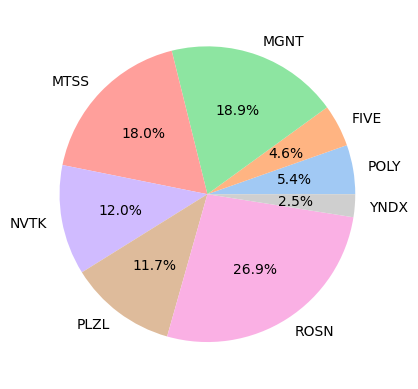

In [128]:
make_pie_graph_weights(cleaned_opt_weights)

In [110]:
ef.portfolio_performance(verbose=True, risk_free_rate=rfr)
# volatility = std(portfolio)

Expected annual return: 26.3%
Annual volatility: 26.4%
Sharpe Ratio: 0.92


(0.2634461209660971, 0.2636067435152146, 0.9235200804035808)

In [122]:
def plot_efficient_frontier(ef):
    fig, ax = plt.subplots()
    ef_max_sharpe = ef.deepcopy()
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, show_tickers=True)

    # Find the tangency portfolio
    ef_max_sharpe.max_sharpe()
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with random portfolios")
    ax.legend()
    plt.tight_layout()
    # plt.savefig("ef_scatter.png", dpi=200)
    plt.show();

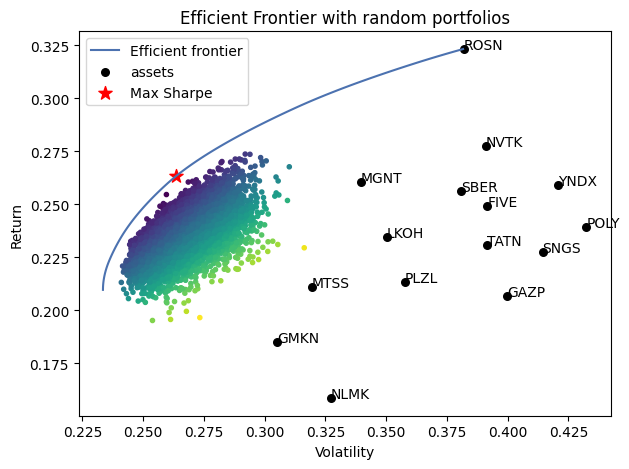

In [123]:
plot_efficient_frontier(
    EfficientFrontier(exp_returns, assets_cov, weight_bounds=(0,1))
)

In [100]:
###
df_assets111 = df_assets.copy(); df_benchmark111 = df_benchmark.copy()
ret = expected_returns.capm_return(
    df_assets111, market_prices = df_benchmark111, compounding=False,
    returns_data=False, risk_free_rate=rfr, frequency=252
)
ret * 100

POLY    11.181453
FIVE    11.002876
GAZP    10.638687
GMKN    11.090721
LKOH    10.764315
MGNT    11.004758
MTSS    11.120621
NLMK    11.100413
NVTK    10.790100
PLZL    11.209422
ROSN    10.580203
SBER    10.574628
SNGS    10.743958
TATN    10.614557
YNDX    10.778107
Name: mkt, dtype: float64

In [101]:
###
df_assets112 = df_assets.copy(); df_benchmark112 = df_benchmark.copy()
ret1 = expected_returns.capm_return(
    df_assets112, market_prices = df_benchmark112, compounding=False,
    returns_data=False, risk_free_rate=rfr, frequency=252
)
ret1 * 100 / 12

POLY    0.931788
FIVE    0.916906
GAZP    0.886557
GMKN    0.924227
LKOH    0.897026
MGNT    0.917063
MTSS    0.926718
NLMK    0.925034
NVTK    0.899175
PLZL    0.934119
ROSN    0.881684
SBER    0.881219
SNGS    0.895330
TATN    0.884546
YNDX    0.898176
Name: mkt, dtype: float64